# DS-I Africa Deep Learning Course - 1 July 2023
## Mandla Gwetu (mvgcollab@gmail.com)

In [2]:
from google.colab import drive
drive.mount('/mntDrive') #, force_remount=True)

Mounted at /mntDrive


['/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/100.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/101.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/102.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/103.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/104.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/105.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/106.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/107.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/108.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/109.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/111.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/112.csv', '/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/113.csv', '/mntDrive/

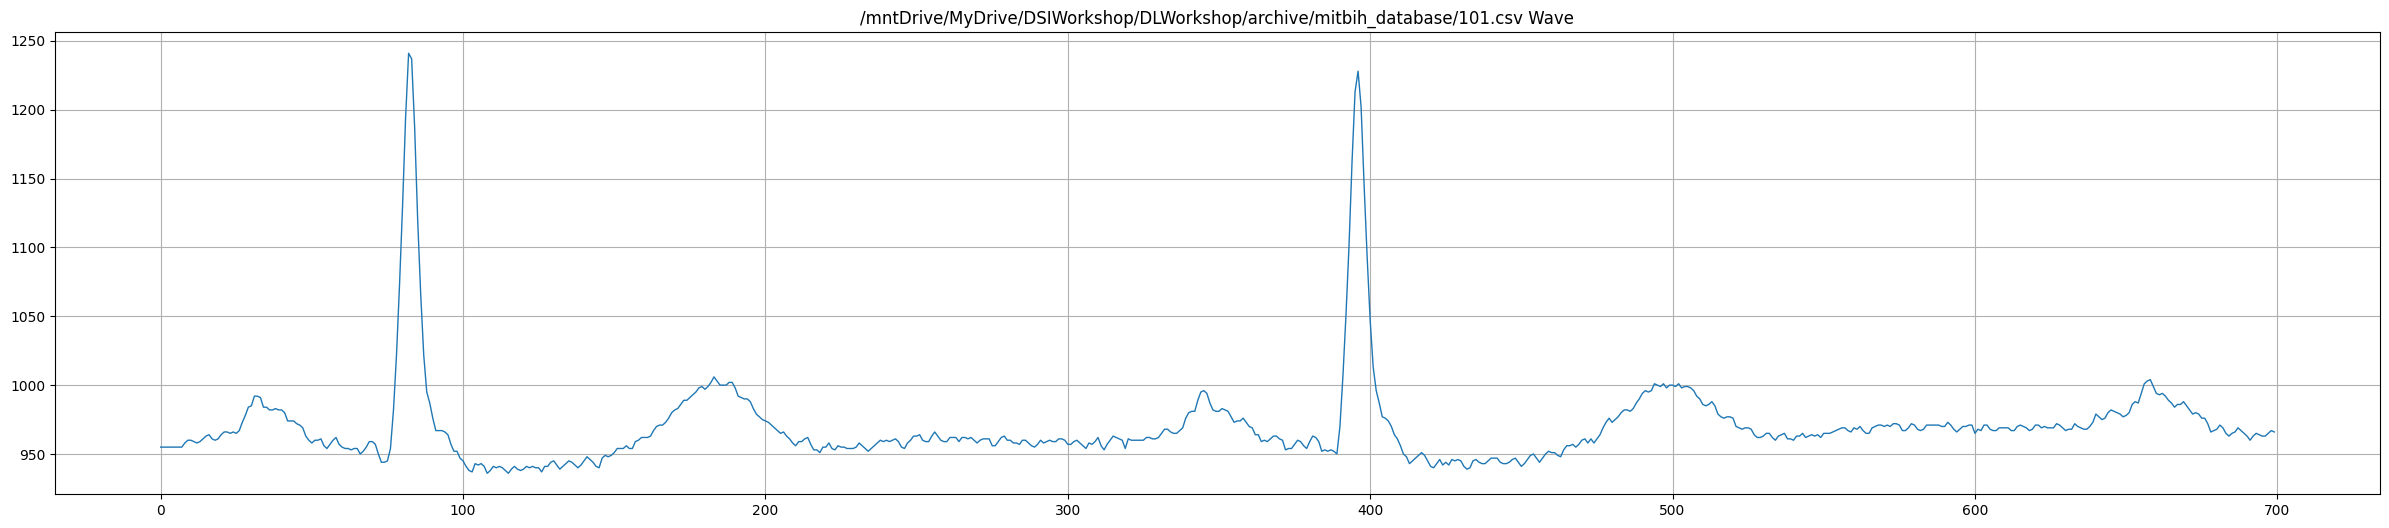

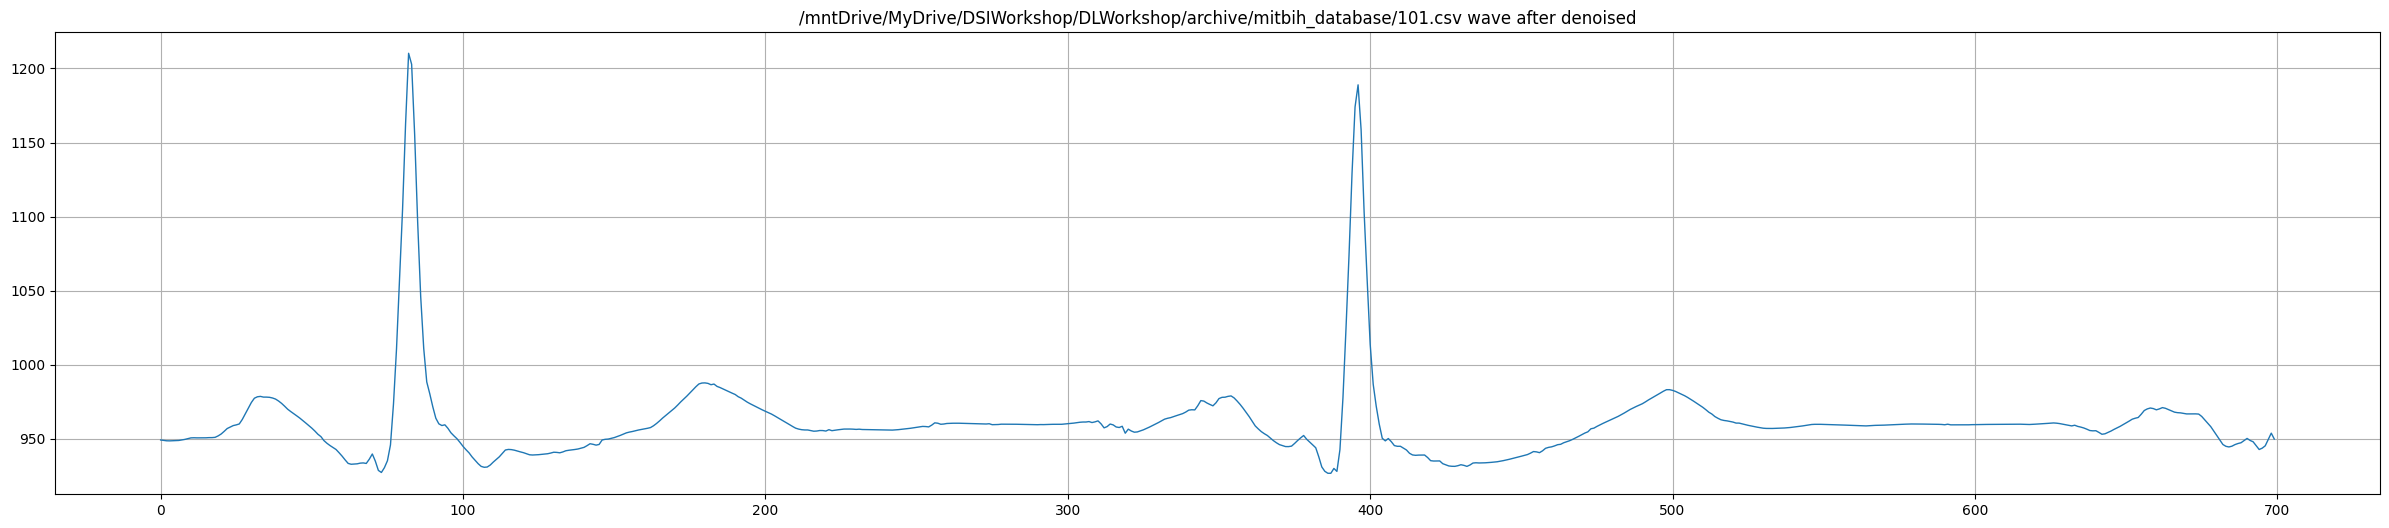

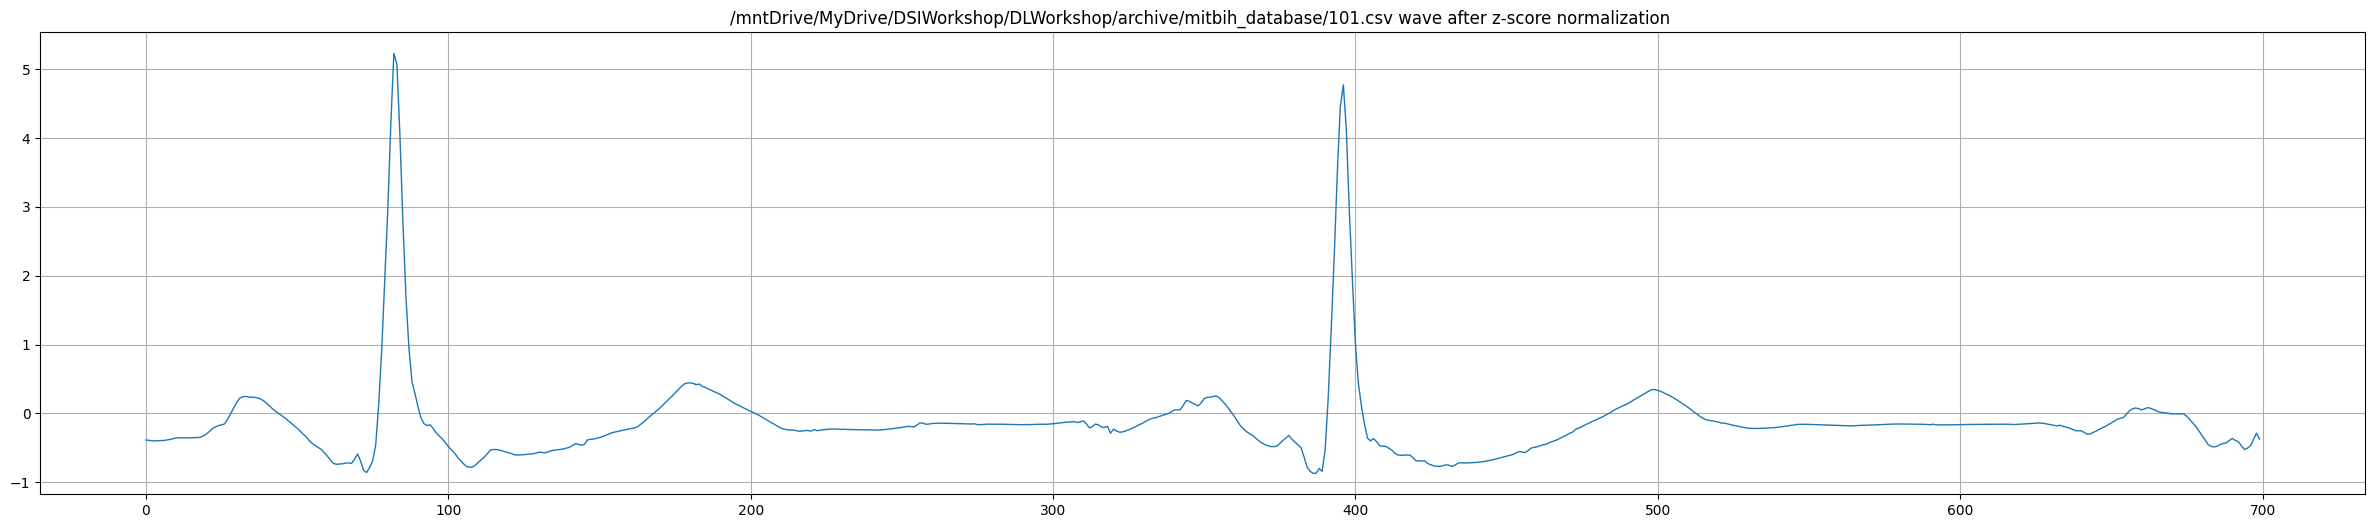

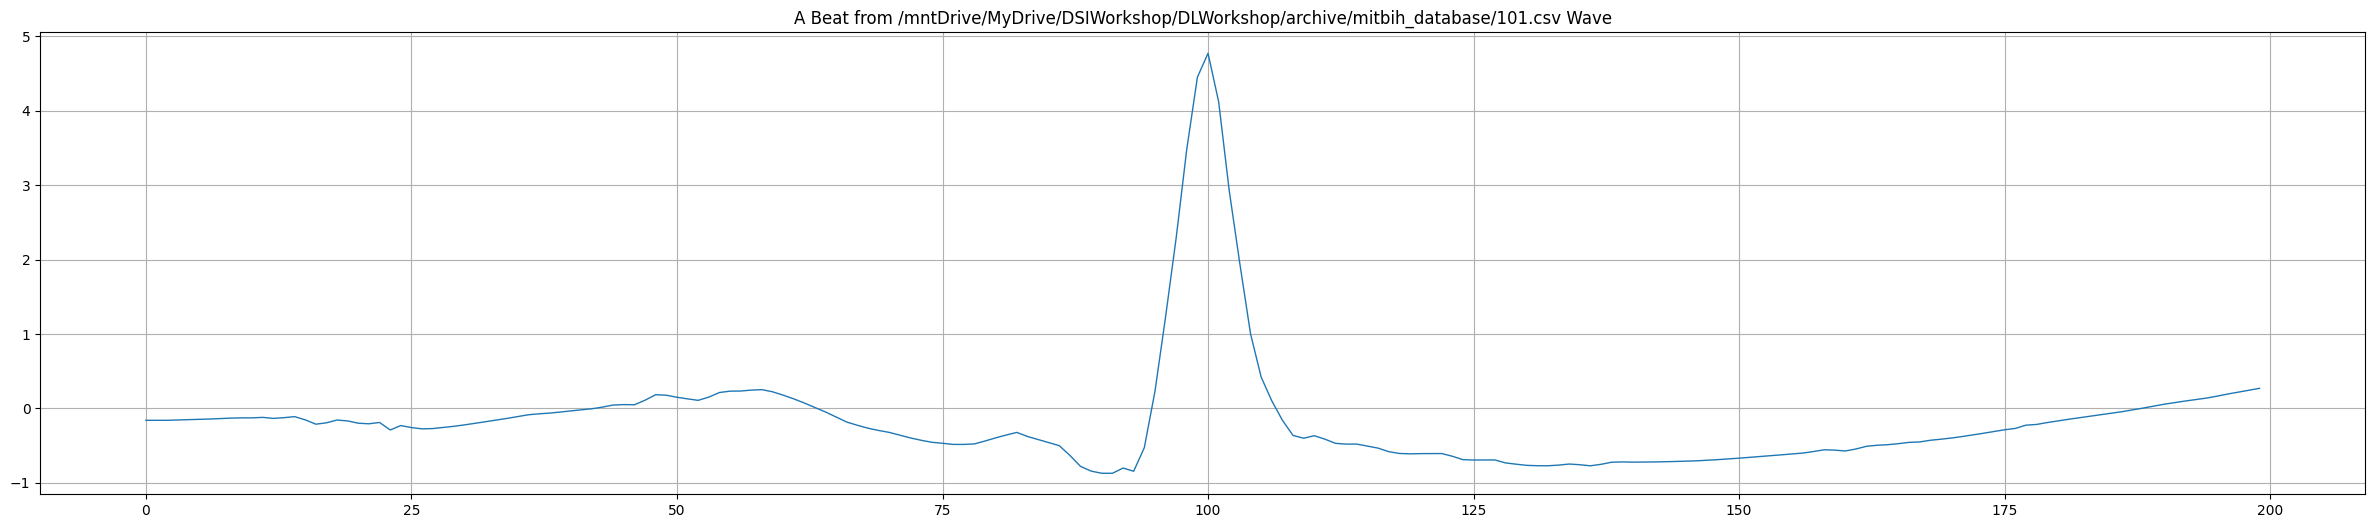

(100033, 200) (100033,)
(100033, 201)
0.0    75028
1.0     8073
2.0     7257
4.0     7129
3.0     2546
Name: 200, dtype: int64


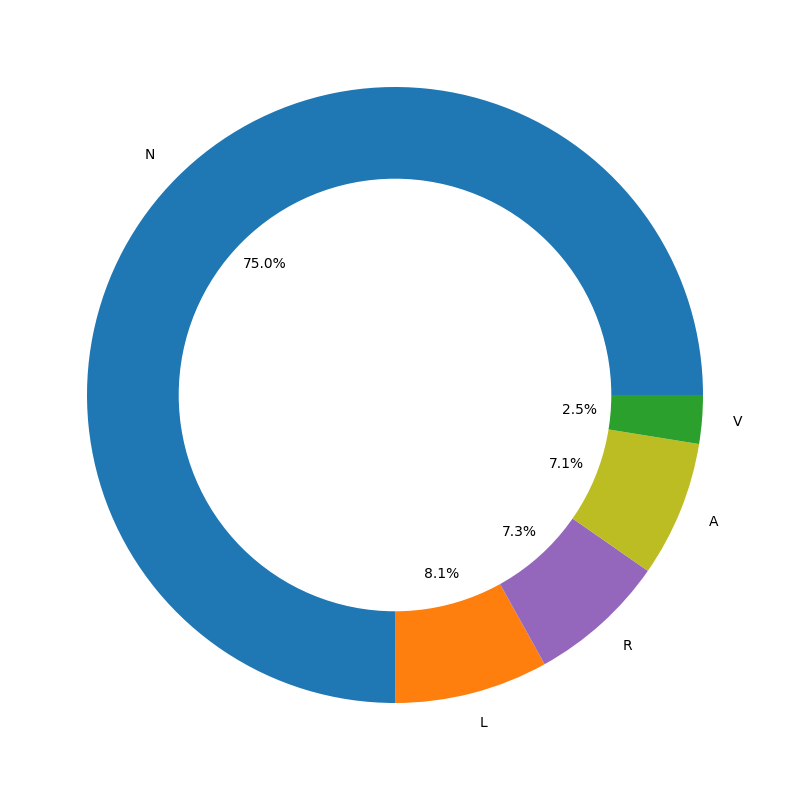

0.0    10000
1.0    10000
2.0    10000
3.0    10000
4.0    10000
Name: 200, dtype: int64


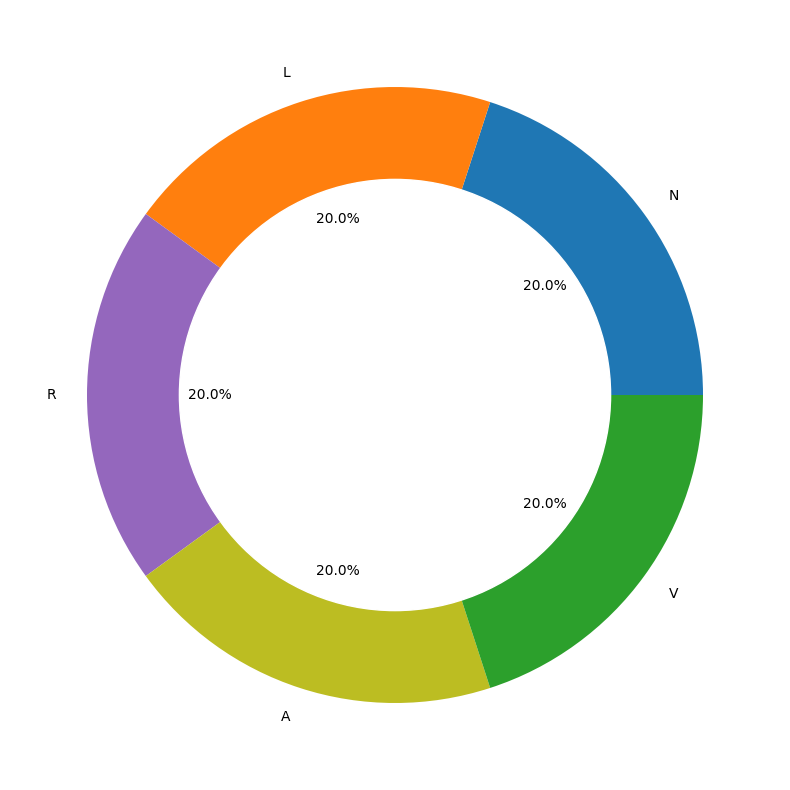

X_train :  (40000, 201)
X_test  :  (10000, 201)
(40000, 5) (10000, 5)
(40000, 200, 1) (10000, 200, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 19,269
Trainable params: 19,205
Non-trainable params: 64
_________________________________________________________________
Model: "sequent

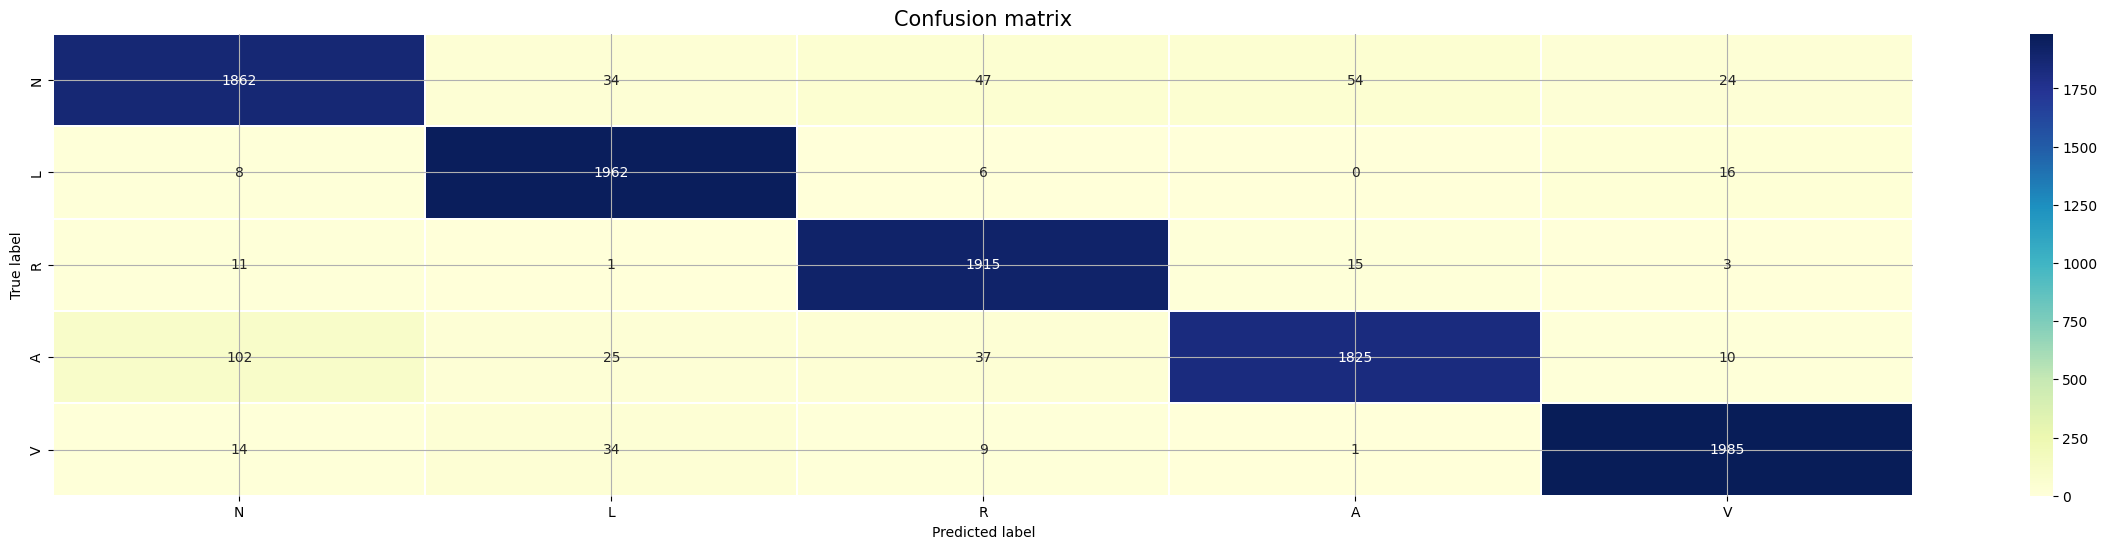

In [3]:
#Credit for this code is attributed to https://github.com/sidhunk/HCAADUMMDLT
#Minor adjustments have been made to file paths
#The dataset has been downloaded from https://physionet.org/content/mitdb/1.0.0/
# Necessary Imports for the project
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

# %matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import LeakyReLU
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Add, Embedding, Conv1DTranspose, RepeatVector, Softmax, Conv1D, \
    Flatten, UpSampling1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import BatchNormalization

from keras.models import model_from_json
from sklearn.metrics import accuracy_score
import warnings
import glob

import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix



# Configurations for Plottingss
plt.rcParams["figure.figsize"] = (30, 6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True


###################


# Noise removal Function
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04  # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))
    datarec = pywt.waverec(coeffs, 'sym4')
    return datarec


###################


# Setting initial parameters for preprocessing
window_size = 100
maximum_counting = 10000
###################


# Defining class labels
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0] * n_classes
###################


# Creating lists for the division of features and labels
path = "/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/"
X = list()
y = list()
filenames = os.listdir("/mntDrive/MyDrive/DSIWorkshop/DLWorkshop/archive/mitbih_database/")
records = list()
annotations = list()
filenames.sort()
###################


# Combining attributes, features and lebels of same record to form a single file
for f in filenames:

    filename, file_extension = os.path.splitext(f)

    if file_extension == '.csv':
        records.append(path + filename + file_extension)

    else:
        annotations.append(path + filename + file_extension)
print(records)
###################


# Data CLeaning, Normalization and Noise Removal (Converting lead data into a continuous signal)
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')  # read CSV file\
        row_index = -1
        for row in spamreader:
            if row_index >= 0:
                signals.insert(row_index, int(row[1]))
            row_index += 1

    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)

    if r == 1:
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)

    if r == 1:
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)
            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size:pos + window_size]

                    if r == 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))
###################


# Creating a single list with features and target labels
for i in range(0, len(X)):
    X[i] = np.append(X[i], y[i])
    # X[i].append(y[i])

print(np.shape(X))
###################


# Plotting Unbalanced Classes
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1] - 1].value_counts()
print(per_class)
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
###################


# Data Re-sampling
df_1 = X_train_df[X_train_df[X_train_df.shape[1] - 1] == 1]
df_2 = X_train_df[X_train_df[X_train_df.shape[1] - 1] == 2]
df_3 = X_train_df[X_train_df[X_train_df.shape[1] - 1] == 3]
df_4 = X_train_df[X_train_df[X_train_df.shape[1] - 1] == 4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0 = (X_train_df[X_train_df[X_train_df.shape[1] - 1] == 0]).sample(n=10000, random_state=42)

df_1_upsample = resample(df_1, replace=True, n_samples=10000, random_state=122)
df_2_upsample = resample(df_2, replace=True, n_samples=10000, random_state=123)
df_3_upsample = resample(df_3, replace=True, n_samples=10000, random_state=124)
df_4_upsample = resample(df_4, replace=True, n_samples=10000, random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])
###################


# Plotting Balanced Classes
per_class = X_train_df[X_train_df.shape[1] - 1].value_counts()
print(per_class)
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
###################


# Splitting Testing-Training data + Data shaping
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

target_train = train[train.shape[1] - 1]
target_test = test[test.shape[1] - 1]
train_y = to_categorical(target_train)
test_y = to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))


train_x = train.iloc[:, :train.shape[1] - 1].values
test_x = test.iloc[:, :test.shape[1] - 1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1], 1)
test_x = test_x.reshape(len(test_x), test_x.shape[1], 1)
print(np.shape(train_x), np.shape(test_x))
###################


############################### Modeling Neural Networks


# LSTM
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.LSTM(units=64, input_shape=(200, 1)))
model1.add(Dense(32, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(Dense(5, activation='softmax'))
model1.summary()

opt = tf.keras.optimizers.Adam()
model1.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# historyL = model1.fit(train_x, train_y, epochs = 5, validation_split = 0.20, batch_size = 180, verbose = 1)

"""Finding the loss and accuracy of LSTM"""

# loss, accuracy = model1.evaluate(test_x, test_y, batch_size = 180, verbose = 1)
# print("Test Accuracy :", accuracy*100,'%')
# print("Test Loss :", loss)


# predictionsL = model1.predict(test_x)
# max_testL = np.argmax(test_y, axis=1)
# max_predictionsL = np.argmax(predictionsL, axis=1)
###################


# CNN
model2 = tf.keras.Sequential()
model2.add(tf.keras.Input(shape=(200, 1)))

model2.add(Conv1D(2, kernel_size=8, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2, strides=1))

model2.add(Conv1D(2, kernel_size=18, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2, strides=1))

model2.add(Conv1D(2, kernel_size=36, strides=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2, strides=1))

model2.add(tf.keras.layers.Flatten(data_format=None))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(5, activation='softmax'))
model2.summary()

model2.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# historyC = model2.fit(train_x, train_y, epochs = 50, validation_split = 0.20, batch_size = 180, verbose = 1)

"""Finding the loss and accuracy of CNN"""

# loss, accuracy = model2.evaluate(test_x, test_y, batch_size = 360, verbose = 1)
# print("Test Accuracy :", accuracy*100,'%')
# print("Test Loss :", loss)

# predictionsC = model2.predict(test_x)
# max_testC = np.argmax(test_y, axis=1)
# max_predictionsC = np.argmax(predictionsC, axis=1)
###################


############################### Merging and Training the merged model

mergedOut = Add()([model1.output, model2.output])
mergedModel = Model([model1.input, model2.input], mergedOut)
mergedModel.summary()

mergedModel.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

mergedModel.fit([train_x, train_x], train_y, epochs=25, batch_size=100, shuffle=False)

predictionsM = mergedModel.predict([test_x, test_x])
print(predictionsM.shape)
predictionsM = np.argmax(predictionsM, axis=1)
test_MM = np.argmax(test_y, axis=1)

# Merged Model Accuracy
print(predictionsM)

Accuracy = accuracy_score(test_MM, predictionsM)
Accuracy = Accuracy * 100
print('Merged Model Accuracy:', Accuracy, '%')

############################### Generating confusion matrix of HEARTBEATS
class_labels = ['N', 'L', 'R', 'A', 'V']
confusion_matrix = confusion_matrix(test_MM, predictionsM)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, linewidths=0.1, fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#######################################################################################################################
